Import libraries

In [1]:
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Read the file

In [2]:
path = 'data/gps230120g002.hdf5'

file = h5py.File(path, 'r')

dataset = file['Data'].get('Table Layout') # type: ignore
data_array = np.array(dataset)


dataset1 = file['Data']['Array Layout']['2D Parameters']['tec'] # type: ignore
tec_array = np.array(dataset1)

file.close()

C:\Users\virtanem\AppData\Local\Temp\ipykernel_2200\3072371395.py:6: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  data_array = np.array(dataset)
C:\Users\virtanem\AppData\Local\Temp\ipykernel_2200\3072371395.py:10: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  tec_array = np.array(dataset1)


Form a pandas dataframe

In [3]:
df = pd.DataFrame(data_array)
df['minute'] = df['min']
df['second'] = df['sec']
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour', 'minute', 'second']])
df = df.drop(['recno','kindat','kinst','ut1_unix','ut2_unix', 
'year', 'month', 'day', 'hour', 'minute', 'second', 'min', 'sec'], axis=1)

Read the rest of the files

In [4]:
path = 'data/gps230121g002.hdf5'

file = h5py.File(path, 'r')

dataset = file['Data'].get('Table Layout') # type: ignore
data_array = np.array(dataset)

file.close()

df2 = pd.DataFrame(data_array)
df2['minute'] = df2['min']
df2['second'] = df2['sec']
df2['datetime'] = pd.to_datetime(df2[['year', 'month', 'day', 'hour', 'minute', 'second']])
df2 = df2.drop(['recno','kindat','kinst','ut1_unix','ut2_unix', 'year', 'month', 'day', 'hour', 'minute', 'second', 'min', 'sec'], axis=1)

C:\Users\virtanem\AppData\Local\Temp\ipykernel_2200\3532978365.py:6: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  data_array = np.array(dataset)


In [5]:
path = 'data/gps230122g002.hdf5'

file = h5py.File(path, 'r')

dataset = file['Data'].get('Table Layout') # type: ignore
data_array = np.array(dataset)

file.close()

df3 = pd.DataFrame(data_array)
df3['minute'] = df3['min']
df3['second'] = df3['sec']
df3['datetime'] = pd.to_datetime(df3[['year', 'month', 'day', 'hour', 'minute', 'second']])
df3 = df3.drop(['recno','kindat','kinst','ut1_unix','ut2_unix', 'year', 'month', 'day', 'hour', 'minute', 'second', 'min', 'sec'], axis=1)

C:\Users\virtanem\AppData\Local\Temp\ipykernel_2200\181550216.py:6: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  data_array = np.array(dataset)


Join the dataframes

In [6]:
# LAT, LON = [55,70], [11,23] #RUOTSI
# LAT, LON = [65,69], [14,23] #NORRA NORRLAND
# LAT, LON = [61,65], [12,22] #SÖDRA NORRLAND
# LAT, LON = [59,61], [11,19] #SVEALAND
# LAT, LON = [55,59], [11,17] #GÖTALAND

LAT = [65,69]
LONG = 20

df = pd.concat([df, df2, df3], axis=0, ignore_index=True)
df = df.loc[(df['gdlat'] >= LAT[0]) & (df['gdlat'] <= LAT[1]) & (df['glon'] == LONG)]
df = df.sort_values(by=['gdlat', 'datetime'], ascending=True)
df

,gdlat,glon,tec,dtec,datetime
14055,65.0,20.0,5.355815,0.284263,2023-01-20 00:02:30
29388,65.0,20.0,5.037913,0.271568,2023-01-20 00:07:30
44556,65.0,20.0,4.806290,0.271481,2023-01-20 00:12:30
60110,65.0,20.0,5.027745,0.271560,2023-01-20 00:17:30
76122,65.0,20.0,4.919833,0.230294,2023-01-20 00:22:30
...,...,...,...,...,...
13210459,69.0,20.0,7.495093,0.198640,2023-01-22 23:37:30
13225738,69.0,20.0,7.119190,0.193041,2023-01-22 23:42:30
13240860,69.0,20.0,7.045915,0.268916,2023-01-22 23:47:30
13256395,69.0,20.0,6.660797,0.329937,2023-01-22 23:52:30


Plot the plot


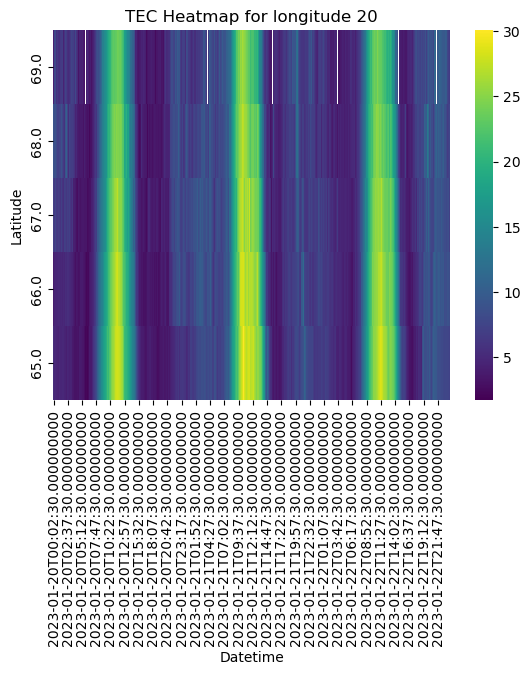

In [7]:
pivot1 = df.pivot(index='gdlat', columns='datetime', values='tec')
sns.heatmap(pivot1, cmap='viridis')

plt.xlabel('Datetime')
plt.ylabel('Latitude')
plt.title(f'TEC Heatmap for longitude {LONG}')
plt.gca().invert_yaxis()

plt.show()

Rolling average

In [8]:
rolling_df = pd.DataFrame()

for lat in df['gdlat'].unique():
    df5 = df.loc[df['gdlat'] == lat]
    moving_avg = df5['tec'].rolling(window=36, min_periods=1, center=True).mean()
    rolling_df = pd.concat([rolling_df, moving_avg], axis=0)

df = pd.concat([df, rolling_df], axis=1)
df['rolling'] = df[0]
df = df.drop(columns=[0])

In [9]:
df['detrended_tec'] = df['tec'] - df['rolling']
df['detrended_tec'].describe()

count    4302.000000
mean       -0.000960
std         1.234734
min        -5.543944
25%        -0.686940
50%        -0.041207
75%         0.657816
max         5.618336
Name: detrended_tec, dtype: float64

Virhedata

In [10]:
# path2 = 'data/ruots/gotaland.csv'
path2 = 'data/ruots/norra_norrland.csv'
# path2 = 'data/ruots/sodra_norrland.csv'
# path2 = 'data/ruots/svealand.csv'

dfv = pd.read_csv(path2, header=None, sep=';')

In [11]:
DT1, DT2 = '2023-01-20 00:00:00', '2023-01-23 00:00:00'

dfv['datetime'] = pd.to_datetime(dfv[0])
dfv['i95'] = dfv[1].str.replace(',', '.').astype(float)
dfv.drop([0, 1], axis=1, inplace=True)
dfv = dfv.loc[(dfv['datetime'] >= DT1) & (dfv['datetime'] <= DT2)]

plot 

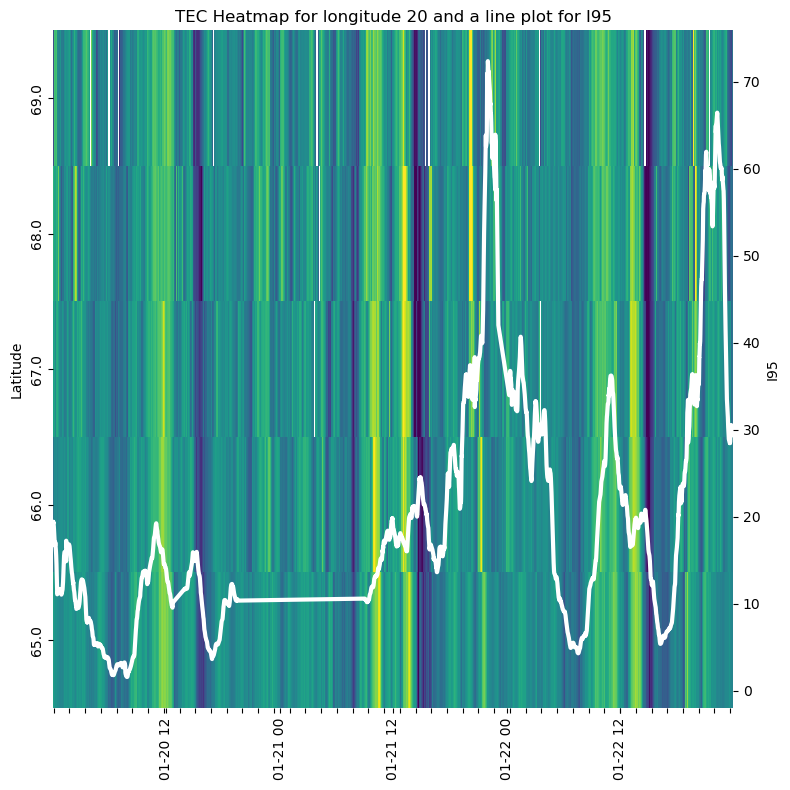

In [12]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

pivot = df.pivot(index='gdlat', columns='datetime', values='detrended_tec')

min_x = df['datetime'].min()
max_x = df['datetime'].max()

ax.set_xlim(min_x, max_x)
g1 = sns.heatmap(pivot, cmap='viridis', vmin=-4, vmax=4, ax=ax, cbar=False)
ax.invert_yaxis()
g1.set(xlabel=None, ylabel = 'Latitude', title = f'TEC Heatmap for longitude {LONG} and a line plot for I95')
ax.set_xticklabels([])


ax2 = fig.add_subplot(111)
ax2.plot(dfv['datetime'], dfv['i95'], color='white', zorder=10, lw=3)
ax2.yaxis.set_label_text('I95')
plt.xticks(rotation =90)
ax2.set_xlim(min_x, max_x)
ax2.yaxis.tick_right()
ax2.grid(False)
ax2.patch.set_alpha(0.0) #type: ignore
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.yaxis.set_label_position("right")


plt.tight_layout()

plt.show()